<a href="https://colab.research.google.com/github/Chanura04/ML-Coursework/blob/main/20240955.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [28]:
!pip install keras-tuner 

In [29]:
import pandas as pd
# from google.colab import drive
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import keras_tuner as kt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras import layers, regularizers, optimizers, callbacks, models
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
import tensorflow as tf

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
import random
random.seed(SEED)
tf.random.set_seed(SEED)

## Load the dataset

In [30]:
url_x = "https://raw.githubusercontent.com/Chanura04/ML-Coursework/main/dataset/processed/set_01/X.csv"
url_y = "https://raw.githubusercontent.com/Chanura04/ML-Coursework/main/dataset/processed/set_01/y_data.csv"

## Check dataset behaviour

In [31]:
X=pd.read_csv(url_x)
y=pd.read_csv(url_y)
X.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,0,0,1,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,0,34,1,0,1,0,1,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,0,0,2,1,0,1,1,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0,0,45,0,0,1,0,1,1,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0,2,1,0,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
X["TotalCharges"]

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [33]:
y.head()

,Churn
0,0
1,0
2,1
3,0
4,1


In [34]:
X.shape

(7043, 25)

In [35]:
y.shape

(7043, 1)

### Split Data into Training, Validation, and Test Sets

In [36]:
# X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_temp, y_train, y_temp= train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test= train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (4930, 25)
Shape of y_train: (4930, 1)
Shape of X_val: (1056, 25)
Shape of y_val: (1056, 1)
Shape of X_test: (1057, 25)
Shape of y_test: (1057, 1)


In [37]:
np.sum(y_val==1)

c:\Users\chanu\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Churn    280
dtype: int64

In [38]:
np.sum(y_val==0)

Churn    776
dtype: int64

In [39]:
# Initialize the scaler
scaler = StandardScaler()

# FIT AND TRANSFORM the training data 
X_train = scaler.fit_transform(X_train)

# TRANSFORM the test data 
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [40]:
X_train[0]

array([-0.43814715, -0.96295739, -0.65086184, -1.11472828,  0.33445908,
       -0.85678685, -0.63699286, -0.73200106, -0.73265479, -0.64581257,
        1.2409383 , -0.80242214, -1.20529512,  0.50428615, -0.83787772,
       -0.72059725,  1.12453737, -0.52587133,  0.90731739, -0.51517027,
       -0.5647009 , -0.53152442, -0.52555704,  1.40735673, -0.54312331])

In [41]:
y_train = y_train.squeeze()    
y_val   = y_val.squeeze()
y_test  = y_test.squeeze()

Text(0.5, 1.0, 'Count Plot for Churn')

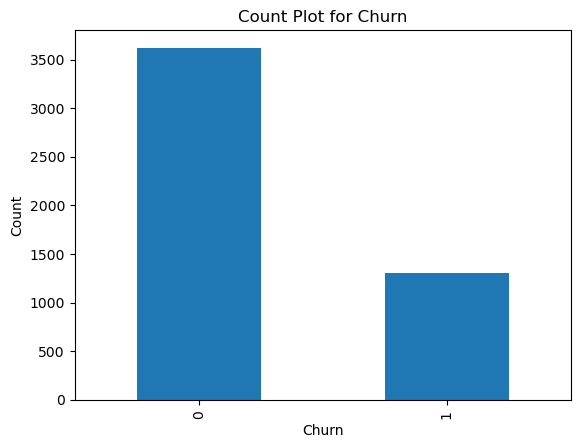

In [42]:
count=y_train.value_counts()
count.plot(kind='bar')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Count Plot for Churn')

Text(0.5, 1.0, 'Count Plot for Churn')

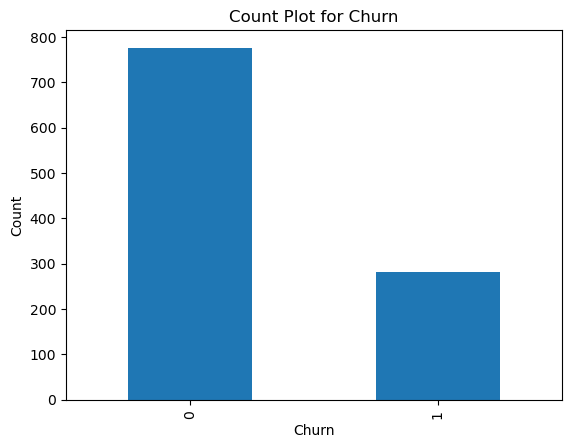

In [43]:
count=y_test.value_counts()
count.plot(kind='bar')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Count Plot for Churn')

In [44]:
def plot_history(history):
    # Loss
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Binary Crossentropy")
    plt.legend()


    # Accuracy
    plt.subplot(1,3,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()


    # AUC
    plt.subplot(1,3,3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title("AUC Curve")
    plt.xlabel("Epochs")
    plt.ylabel("AUC Score")
    plt.legend()
    plt.show()





## Train Neural Network

#### Experiment 01

In [45]:
input_dim=X_train.shape[1]
input_dim

25

In [46]:
# ,kernel_regularizer=keras.regularizers.l2(0.001) 

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

Class weights: {0: np.float64(0.680563224737714), 1: np.float64(1.8845565749235473)}


In [48]:
def make_baseline_model(input_dim):

    model = models.Sequential([
        layers.InputLayer(input_shape=(input_dim,)),

        # layers.Dense(512, activation='relu'),
        # layers.Dropout(0.3),

        # layers.Dense(256, activation='relu'),
        # layers.Dropout(0.3),
        
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        

        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(1, activation='sigmoid')
    ])

    return model

model=make_baseline_model(input_dim)
model.summary()


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC(name='auc'), 'accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')
            ]
)

callabacks_list = [
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=20,
        mode='max',
        restore_best_weights=True,
        verbose=1),

    # callbacks.ReduceLROnPlateau(
    #     monitor='val_auc',
    #     factor=0.5,
    #     patience=10,
    #     min_lr=1e-6,
    #     verbose=1),
    
    callbacks.ModelCheckpoint(
        filepath='best_model_2.h5',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1)
]


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=64,
    callbacks=callabacks_list,
    verbose=2,
    class_weight=class_weight_dict

)

c:\Users\chanu\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,697 (53.50 KB)

 Trainable params: 13,697 (53.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150

Epoch 1: val_auc improved from None to 0.80136, saving model to best_model_2.h5


78/78 - 2s - 23ms/step - accuracy: 0.4886 - auc: 0.6559 - loss: 0.6648 - precision: 0.3201 - recall: 0.8249 - val_accuracy: 0.6733 - val_auc: 0.8014 - val_loss: 0.6296 - val_precision: 0.4381 - val_recall: 0.8214
Epoch 2/150

Epoch 2: val_auc improved from 0.80136 to 0.81965, saving model to best_model_2.h5


78/78 - 0s - 3ms/step - accuracy: 0.6359 - auc: 0.7492 - loss: 0.6051 - precision: 0.4027 - recall: 0.7706 - val_accuracy: 0.7358 - val_auc: 0.8196 - val_loss: 0.5747 - val_precision: 0.5012 - val_recall: 0.7750
Epoch 3/150

Epoch 3: val_auc improved from 0.81965 to 0.82627, saving model to best_model_2.h5


78/78 - 0s - 2ms/step - accuracy: 0.6892 - auc: 0.7739 - loss: 0.5775 - precision: 0.4490 - recall: 0.7546 - val_accuracy: 0.7434 - val_auc: 0.8263 - val_loss: 0.5482 - val_precision: 0.5104 - val_recall: 0.7857
Epoch 4/150

Epoch 4: val_auc improved from 0.82627 to 0.82898, saving model to best_model_2.h5


78/78 - 0s - 2ms/step - accuracy: 0.7122 - auc: 0.7925 - loss: 0.5589 - precision: 0.4734 - recall: 0.7561 - val_accuracy: 0.7424 - val_auc: 0.8290 - val_loss: 0.5390 - val_precision: 0.5091 - val_recall: 0.7964
Epoch 5/150

Epoch 5: val_auc improved from 0.82898 to 0.83098, saving model to best_model_2.h5


78/78 - 0s - 3ms/step - accuracy: 0.7097 - auc: 0.7957 - loss: 0.5522 - precision: 0.4709 - recall: 0.7607 - val_accuracy: 0.7386 - val_auc: 0.8310 - val_loss: 0.5352 - val_precision: 0.5045 - val_recall: 0.8036
Epoch 6/150

Epoch 6: val_auc improved from 0.83098 to 0.83212, saving model to best_model_2.h5


78/78 - 0s - 3ms/step - accuracy: 0.7213 - auc: 0.8049 - loss: 0.5418 - precision: 0.4841 - recall: 0.7683 - val_accuracy: 0.7415 - val_auc: 0.8321 - val_loss: 0.5269 - val_precision: 0.5079 - val_recall: 0.8036
Epoch 7/150

Epoch 7: val_auc improved from 0.83212 to 0.83310, saving model to best_model_2.h5


78/78 - 0s - 2ms/step - accuracy: 0.7292 - auc: 0.8119 - loss: 0.5318 - precision: 0.4934 - recall: 0.7752 - val_accuracy: 0.7434 - val_auc: 0.8331 - val_loss: 0.5222 - val_precision: 0.5102 - val_recall: 0.8071
Epoch 8/150

Epoch 8: val_auc improved from 0.83310 to 0.83407, saving model to best_model_2.h5


78/78 - 0s - 3ms/step - accuracy: 0.7327 - auc: 0.8149 - loss: 0.5278 - precision: 0.4975 - recall: 0.7714 - val_accuracy: 0.7320 - val_auc: 0.8341 - val_loss: 0.5246 - val_precision: 0.4967 - val_recall: 0.8107
Epoch 9/150

Epoch 9: val_auc improved from 0.83407 to 0.83457, saving model to best_model_2.h5


78/78 - 0s - 2ms/step - accuracy: 0.7290 - auc: 0.8140 - loss: 0.5317 - precision: 0.4932 - recall: 0.7798 - val_accuracy: 0.7301 - val_auc: 0.8346 - val_loss: 0.5228 - val_precision: 0.4946 - val_recall: 0.8179
Epoch 10/150

Epoch 10: val_auc improved from 0.83457 to 0.83505, saving model to best_model_2.h5


78/78 - 0s - 3ms/step - accuracy: 0.7396 - auc: 0.8236 - loss: 0.5164 - precision: 0.5059 - recall: 0.7920 - val_accuracy: 0.7282 - val_auc: 0.8351 - val_loss: 0.5194 - val_precision: 0.4924 - val_recall: 0.8107
Epoch 11/150

Epoch 11: val_auc improved from 0.83505 to 0.83557, saving model to best_model_2.h5


78/78 - 0s - 5ms/step - accuracy: 0.7438 - auc: 0.8253 - loss: 0.5159 - precision: 0.5112 - recall: 0.7859 - val_accuracy: 0.7320 - val_auc: 0.8356 - val_loss: 0.5159 - val_precision: 0.4967 - val_recall: 0.8143
Epoch 12/150

Epoch 12: val_auc improved from 0.83557 to 0.83571, saving model to best_model_2.h5


78/78 - 0s - 4ms/step - accuracy: 0.7347 - auc: 0.8205 - loss: 0.5224 - precision: 0.5000 - recall: 0.7798 - val_accuracy: 0.7244 - val_auc: 0.8357 - val_loss: 0.5203 - val_precision: 0.4882 - val_recall: 0.8143
Epoch 13/150

Epoch 13: val_auc improved from 0.83571 to 0.83589, saving model to best_model_2.h5


78/78 - 0s - 3ms/step - accuracy: 0.7323 - auc: 0.8249 - loss: 0.5154 - precision: 0.4971 - recall: 0.7882 - val_accuracy: 0.7273 - val_auc: 0.8359 - val_loss: 0.5172 - val_precision: 0.4914 - val_recall: 0.8143
Epoch 14/150

Epoch 14: val_auc improved from 0.83589 to 0.83644, saving model to best_model_2.h5


78/78 - 0s - 3ms/step - accuracy: 0.7357 - auc: 0.8265 - loss: 0.5152 - precision: 0.5012 - recall: 0.7943 - val_accuracy: 0.7235 - val_auc: 0.8364 - val_loss: 0.5187 - val_precision: 0.4872 - val_recall: 0.8143
Epoch 15/150

Epoch 15: val_auc improved from 0.83644 to 0.83660, saving model to best_model_2.h5


78/78 - 0s - 3ms/step - accuracy: 0.7341 - auc: 0.8200 - loss: 0.5207 - precision: 0.4993 - recall: 0.7913 - val_accuracy: 0.7244 - val_auc: 0.8366 - val_loss: 0.5157 - val_precision: 0.4882 - val_recall: 0.8143
Epoch 16/150

Epoch 16: val_auc improved from 0.83660 to 0.83692, saving model to best_model_2.h5


78/78 - 0s - 3ms/step - accuracy: 0.7406 - auc: 0.8243 - loss: 0.5153 - precision: 0.5071 - recall: 0.7913 - val_accuracy: 0.7169 - val_auc: 0.8369 - val_loss: 0.5166 - val_precision: 0.4800 - val_recall: 0.8143
Epoch 17/150

Epoch 17: val_auc improved from 0.83692 to 0.83713, saving model to best_model_2.h5


78/78 - 0s - 4ms/step - accuracy: 0.7396 - auc: 0.8249 - loss: 0.5180 - precision: 0.5058 - recall: 0.8066 - val_accuracy: 0.7188 - val_auc: 0.8371 - val_loss: 0.5172 - val_precision: 0.4822 - val_recall: 0.8214
Epoch 18/150

Epoch 18: val_auc improved from 0.83713 to 0.83734, saving model to best_model_2.h5


78/78 - 0s - 3ms/step - accuracy: 0.7363 - auc: 0.8256 - loss: 0.5160 - precision: 0.5019 - recall: 0.7997 - val_accuracy: 0.7169 - val_auc: 0.8373 - val_loss: 0.5180 - val_precision: 0.4801 - val_recall: 0.8179
Epoch 19/150

Epoch 19: val_auc improved from 0.83734 to 0.83762, saving model to best_model_2.h5


78/78 - 0s - 4ms/step - accuracy: 0.7373 - auc: 0.8231 - loss: 0.5190 - precision: 0.5031 - recall: 0.7997 - val_accuracy: 0.7178 - val_auc: 0.8376 - val_loss: 0.5163 - val_precision: 0.4812 - val_recall: 0.8214
Epoch 20/150

Epoch 20: val_auc improved from 0.83762 to 0.83781, saving model to best_model_2.h5


78/78 - 0s - 3ms/step - accuracy: 0.7359 - auc: 0.8330 - loss: 0.5054 - precision: 0.5014 - recall: 0.8028 - val_accuracy: 0.7169 - val_auc: 0.8378 - val_loss: 0.5196 - val_precision: 0.4802 - val_recall: 0.8214
Epoch 21/150

Epoch 21: val_auc improved from 0.83781 to 0.83787, saving model to best_model_2.h5


78/78 - 0s - 2ms/step - accuracy: 0.7375 - auc: 0.8302 - loss: 0.5094 - precision: 0.5034 - recall: 0.8020 - val_accuracy: 0.7178 - val_auc: 0.8379 - val_loss: 0.5170 - val_precision: 0.4811 - val_recall: 0.8179
Epoch 22/150

Epoch 22: val_auc improved from 0.83787 to 0.83831, saving model to best_model_2.h5


78/78 - 0s - 2ms/step - accuracy: 0.7351 - auc: 0.8261 - loss: 0.5117 - precision: 0.5005 - recall: 0.7959 - val_accuracy: 0.7188 - val_auc: 0.8383 - val_loss: 0.5132 - val_precision: 0.4820 - val_recall: 0.8143
Epoch 23/150

Epoch 23: val_auc did not improve from 0.83831
78/78 - 0s - 2ms/step - accuracy: 0.7349 - auc: 0.8315 - loss: 0.5058 - precision: 0.5002 - recall: 0.7982 - val_accuracy: 0.7169 - val_auc: 0.8382 - val_loss: 0.5153 - val_precision: 0.4799 - val_recall: 0.8107
Epoch 24/150

Epoch 24: val_auc did not improve from 0.83831
78/78 - 0s - 2ms/step - accuracy: 0.7396 - auc: 0.8328 - loss: 0.5034 - precision: 0.5057 - recall: 0.8127 - val_accuracy: 0.7140 - val_auc: 0.8379 - val_loss: 0.5153 - val_precision: 0.4769 - val_recall: 0.8107
Epoch 25/150

Epoch 25: val_auc did not improve from 0.83831
78/78 - 0s - 2ms/step - accuracy: 0.7406 - auc: 0.8305 - loss: 0.5077 - precision: 0.5069 - recall: 0.8089 - val_accuracy: 0.7140 - val_auc: 0.8383 - val_loss: 0.5152 - val_precisio

78/78 - 0s - 2ms/step - accuracy: 0.7333 - auc: 0.8306 - loss: 0.5066 - precision: 0.4983 - recall: 0.8005 - val_accuracy: 0.7178 - val_auc: 0.8389 - val_loss: 0.5120 - val_precision: 0.4809 - val_recall: 0.8107
Epoch 27/150

Epoch 27: val_auc did not improve from 0.83885
78/78 - 0s - 2ms/step - accuracy: 0.7408 - auc: 0.8317 - loss: 0.5073 - precision: 0.5072 - recall: 0.8050 - val_accuracy: 0.7159 - val_auc: 0.8386 - val_loss: 0.5120 - val_precision: 0.4789 - val_recall: 0.8107
Epoch 28/150

Epoch 28: val_auc did not improve from 0.83885
78/78 - 0s - 2ms/step - accuracy: 0.7410 - auc: 0.8334 - loss: 0.5068 - precision: 0.5074 - recall: 0.8089 - val_accuracy: 0.7169 - val_auc: 0.8386 - val_loss: 0.5138 - val_precision: 0.4799 - val_recall: 0.8107
Epoch 29/150

Epoch 29: val_auc did not improve from 0.83885
78/78 - 0s - 2ms/step - accuracy: 0.7462 - auc: 0.8379 - loss: 0.4970 - precision: 0.5138 - recall: 0.8096 - val_accuracy: 0.7169 - val_auc: 0.8386 - val_loss: 0.5171 - val_precisio

78/78 - 0s - 2ms/step - accuracy: 0.7432 - auc: 0.8346 - loss: 0.5028 - precision: 0.5101 - recall: 0.8127 - val_accuracy: 0.7188 - val_auc: 0.8392 - val_loss: 0.5153 - val_precision: 0.4820 - val_recall: 0.8143
Epoch 31/150

Epoch 31: val_auc improved from 0.83918 to 0.83920, saving model to best_model_2.h5


78/78 - 0s - 3ms/step - accuracy: 0.7357 - auc: 0.8332 - loss: 0.5033 - precision: 0.5012 - recall: 0.8104 - val_accuracy: 0.7188 - val_auc: 0.8392 - val_loss: 0.5127 - val_precision: 0.4820 - val_recall: 0.8107
Epoch 32/150

Epoch 32: val_auc did not improve from 0.83920
78/78 - 0s - 2ms/step - accuracy: 0.7381 - auc: 0.8327 - loss: 0.5002 - precision: 0.5041 - recall: 0.7989 - val_accuracy: 0.7178 - val_auc: 0.8390 - val_loss: 0.5132 - val_precision: 0.4809 - val_recall: 0.8107
Epoch 33/150

Epoch 33: val_auc did not improve from 0.83920
78/78 - 0s - 2ms/step - accuracy: 0.7341 - auc: 0.8320 - loss: 0.5060 - precision: 0.4993 - recall: 0.8127 - val_accuracy: 0.7188 - val_auc: 0.8385 - val_loss: 0.5157 - val_precision: 0.4820 - val_recall: 0.8107
Epoch 34/150

Epoch 34: val_auc did not improve from 0.83920
78/78 - 0s - 2ms/step - accuracy: 0.7381 - auc: 0.8345 - loss: 0.5000 - precision: 0.5041 - recall: 0.8050 - val_accuracy: 0.7197 - val_auc: 0.8386 - val_loss: 0.5152 - val_precisio

78/78 - 0s - 2ms/step - accuracy: 0.7410 - auc: 0.8377 - loss: 0.4974 - precision: 0.5075 - recall: 0.8058 - val_accuracy: 0.7206 - val_auc: 0.8392 - val_loss: 0.5126 - val_precision: 0.4839 - val_recall: 0.8071
Epoch 41/150

Epoch 41: val_auc improved from 0.83922 to 0.83989, saving model to best_model_2.h5


78/78 - 0s - 3ms/step - accuracy: 0.7426 - auc: 0.8393 - loss: 0.4931 - precision: 0.5094 - recall: 0.8043 - val_accuracy: 0.7225 - val_auc: 0.8399 - val_loss: 0.5105 - val_precision: 0.4860 - val_recall: 0.8071
Epoch 42/150

Epoch 42: val_auc did not improve from 0.83989
78/78 - 0s - 2ms/step - accuracy: 0.7471 - auc: 0.8422 - loss: 0.4928 - precision: 0.5147 - recall: 0.8157 - val_accuracy: 0.7244 - val_auc: 0.8398 - val_loss: 0.5086 - val_precision: 0.4881 - val_recall: 0.8071
Epoch 43/150

Epoch 43: val_auc did not improve from 0.83989
78/78 - 0s - 6ms/step - accuracy: 0.7442 - auc: 0.8396 - loss: 0.4927 - precision: 0.5113 - recall: 0.8104 - val_accuracy: 0.7235 - val_auc: 0.8398 - val_loss: 0.5096 - val_precision: 0.4871 - val_recall: 0.8071
Epoch 44/150

Epoch 44: val_auc did not improve from 0.83989
78/78 - 0s - 3ms/step - accuracy: 0.7452 - auc: 0.8421 - loss: 0.4917 - precision: 0.5126 - recall: 0.8058 - val_accuracy: 0.7225 - val_auc: 0.8397 - val_loss: 0.5106 - val_precisio

78/78 - 0s - 3ms/step - accuracy: 0.7440 - auc: 0.8383 - loss: 0.4952 - precision: 0.5112 - recall: 0.8035 - val_accuracy: 0.7225 - val_auc: 0.8400 - val_loss: 0.5124 - val_precision: 0.4860 - val_recall: 0.8071
Epoch 46/150

Epoch 46: val_auc improved from 0.83999 to 0.84003, saving model to best_model_2.h5


78/78 - 0s - 3ms/step - accuracy: 0.7412 - auc: 0.8399 - loss: 0.4955 - precision: 0.5076 - recall: 0.8127 - val_accuracy: 0.7235 - val_auc: 0.8400 - val_loss: 0.5110 - val_precision: 0.4871 - val_recall: 0.8071
Epoch 47/150

Epoch 47: val_auc did not improve from 0.84003
78/78 - 0s - 2ms/step - accuracy: 0.7501 - auc: 0.8397 - loss: 0.4956 - precision: 0.5184 - recall: 0.8180 - val_accuracy: 0.7225 - val_auc: 0.8396 - val_loss: 0.5126 - val_precision: 0.4860 - val_recall: 0.8071
Epoch 48/150

Epoch 48: val_auc did not improve from 0.84003
78/78 - 0s - 2ms/step - accuracy: 0.7446 - auc: 0.8427 - loss: 0.4895 - precision: 0.5119 - recall: 0.8073 - val_accuracy: 0.7254 - val_auc: 0.8396 - val_loss: 0.5092 - val_precision: 0.4892 - val_recall: 0.8071
Epoch 49/150

Epoch 49: val_auc did not improve from 0.84003
78/78 - 0s - 2ms/step - accuracy: 0.7424 - auc: 0.8412 - loss: 0.4923 - precision: 0.5091 - recall: 0.8089 - val_accuracy: 0.7254 - val_auc: 0.8395 - val_loss: 0.5103 - val_precisio

78/78 - 0s - 5ms/step - accuracy: 0.7460 - auc: 0.8396 - loss: 0.4959 - precision: 0.5136 - recall: 0.8073 - val_accuracy: 0.7244 - val_auc: 0.8405 - val_loss: 0.5108 - val_precision: 0.4881 - val_recall: 0.8071
Epoch 54/150

Epoch 54: val_auc did not improve from 0.84047
78/78 - 0s - 2ms/step - accuracy: 0.7487 - auc: 0.8392 - loss: 0.4952 - precision: 0.5169 - recall: 0.8050 - val_accuracy: 0.7244 - val_auc: 0.8402 - val_loss: 0.5111 - val_precision: 0.4881 - val_recall: 0.8071
Epoch 55/150

Epoch 55: val_auc did not improve from 0.84047
78/78 - 0s - 2ms/step - accuracy: 0.7418 - auc: 0.8394 - loss: 0.4933 - precision: 0.5086 - recall: 0.7920 - val_accuracy: 0.7263 - val_auc: 0.8403 - val_loss: 0.5083 - val_precision: 0.4902 - val_recall: 0.8071
Epoch 56/150

Epoch 56: val_auc improved from 0.84047 to 0.84076, saving model to best_model_2.h5


78/78 - 0s - 3ms/step - accuracy: 0.7491 - auc: 0.8425 - loss: 0.4879 - precision: 0.5175 - recall: 0.8020 - val_accuracy: 0.7254 - val_auc: 0.8408 - val_loss: 0.5081 - val_precision: 0.4891 - val_recall: 0.8036
Epoch 57/150

Epoch 57: val_auc did not improve from 0.84076
78/78 - 0s - 3ms/step - accuracy: 0.7509 - auc: 0.8413 - loss: 0.4945 - precision: 0.5197 - recall: 0.8081 - val_accuracy: 0.7263 - val_auc: 0.8405 - val_loss: 0.5113 - val_precision: 0.4902 - val_recall: 0.8071
Epoch 58/150

Epoch 58: val_auc did not improve from 0.84076
78/78 - 0s - 2ms/step - accuracy: 0.7497 - auc: 0.8438 - loss: 0.4934 - precision: 0.5182 - recall: 0.8073 - val_accuracy: 0.7254 - val_auc: 0.8404 - val_loss: 0.5112 - val_precision: 0.4891 - val_recall: 0.8036
Epoch 59/150

Epoch 59: val_auc did not improve from 0.84076
78/78 - 0s - 2ms/step - accuracy: 0.7396 - auc: 0.8425 - loss: 0.4922 - precision: 0.5058 - recall: 0.8066 - val_accuracy: 0.7235 - val_auc: 0.8405 - val_loss: 0.5109 - val_precisio

78/78 - 0s - 2ms/step - accuracy: 0.7505 - auc: 0.8462 - loss: 0.4846 - precision: 0.5190 - recall: 0.8142 - val_accuracy: 0.7273 - val_auc: 0.8410 - val_loss: 0.5078 - val_precision: 0.4912 - val_recall: 0.8000
Epoch 71/150

Epoch 71: val_auc did not improve from 0.84098
78/78 - 0s - 2ms/step - accuracy: 0.7511 - auc: 0.8442 - loss: 0.4898 - precision: 0.5197 - recall: 0.8165 - val_accuracy: 0.7263 - val_auc: 0.8407 - val_loss: 0.5092 - val_precision: 0.4902 - val_recall: 0.8000
Epoch 72/150

Epoch 72: val_auc did not improve from 0.84098
78/78 - 0s - 2ms/step - accuracy: 0.7436 - auc: 0.8461 - loss: 0.4844 - precision: 0.5107 - recall: 0.8058 - val_accuracy: 0.7273 - val_auc: 0.8409 - val_loss: 0.5078 - val_precision: 0.4912 - val_recall: 0.8000
Epoch 73/150

Epoch 73: val_auc did not improve from 0.84098
78/78 - 0s - 2ms/step - accuracy: 0.7491 - auc: 0.8487 - loss: 0.4824 - precision: 0.5175 - recall: 0.8035 - val_accuracy: 0.7273 - val_auc: 0.8409 - val_loss: 0.5076 - val_precisio

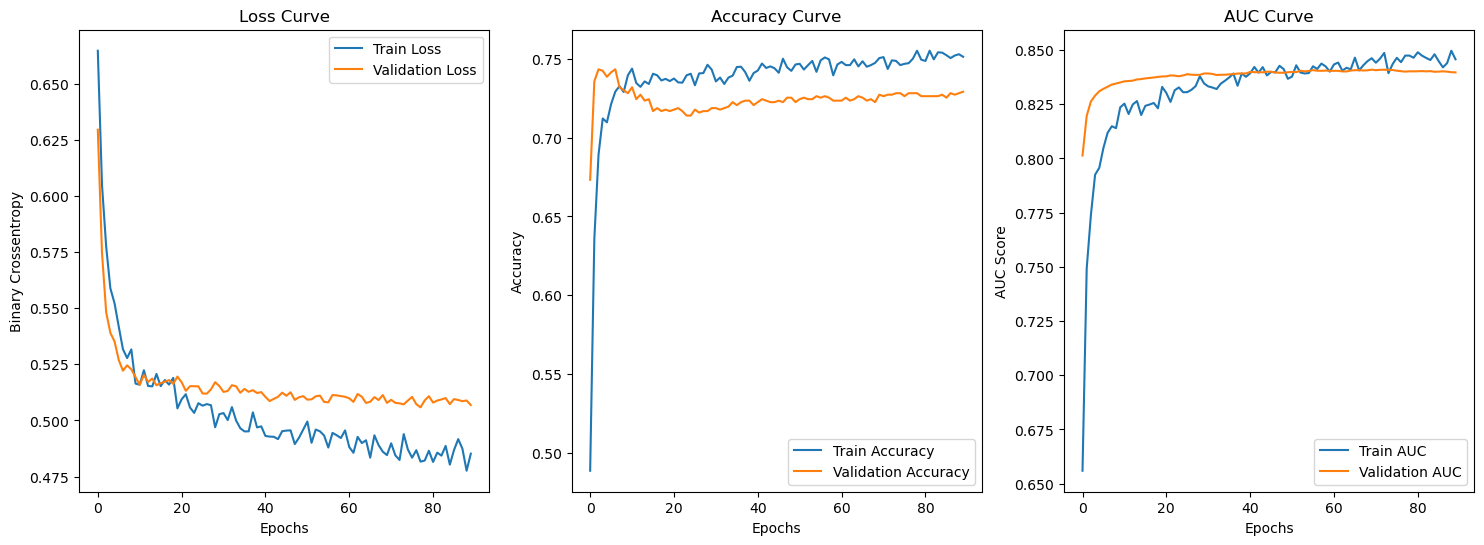

In [49]:
plot_history(history)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


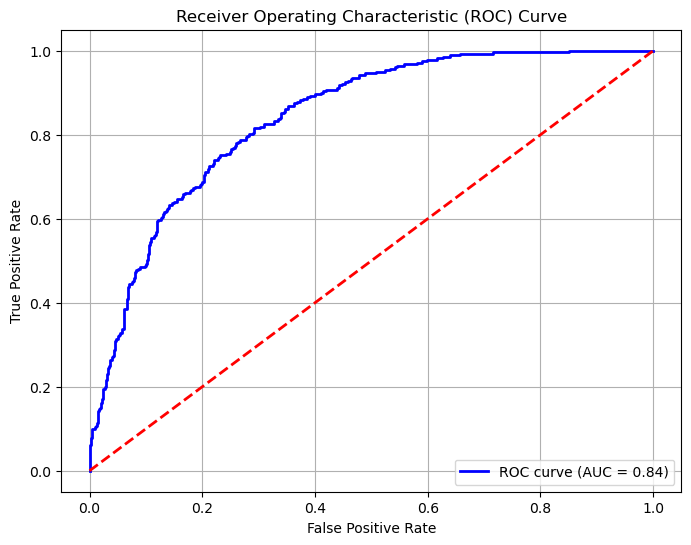

In [50]:
y_pred_prob = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)


plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [54]:
best_model = keras.models.load_model('best_model_2.h5')
test_results = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Test AUC: {accuracy_score(y_test, (best_model.predict(X_test) >= 0.64).astype(int)):.4f}")
print(f"Test Accuracy: {test_results[2]:.4f}")
print(f"Test Precision: {precision_score(y_test, (best_model.predict(X_test) >= 0.64).astype(int)):.4f}")
print(f"Test Recall: {recall_score(y_test, (best_model.predict(X_test) >= 0.64).astype(int)):.4f}")

print("Classification Report:")
print(classification_report(y_test, (best_model.predict(X_test) >= 0.64).astype(int)))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test AUC: 0.7985
Test Accuracy: 0.7474
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
Test Precision: 0.6189
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
Test Recall: 0.6299
Classification Report:
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       776
           1       0.62      0.63      0.62       281

    accuracy                           0.80      1057
   macro avg       0.74      0.74      0.74      1057
weighted avg       0.80      0.80      0.80      1057



In [52]:
# os.makedirs("models", exist_ok=True)
#
# best_tuned_model_test_02.save("models/final_ann_model.keras")
